In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encodgin='bytes')
    return dict

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
dataset = MNIST(root='/Git2020_12_20_Eunjoo/Code_Practice_2020', download=True, transform=ToTensor())

Extracting /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw/train-images-idx3-ubyte.gz to /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw


Extracting /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw/train-labels-idx1-ubyte.gz to /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw


Extracting /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw/t10k-images-idx3-ubyte.gz to /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw




Extracting /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Git2020_12_20_Eunjoo/Code_Practice_2020/MNIST/raw
Processing...


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [7]:
image,label = dataset[0]
print('image.shape:', image.shape)


image.shape: torch.Size([1, 28, 28])


Next, let's use the random_split helper function to set aside 10000 images for our validation set.

In [8]:
val_size = 10000
train_size =len(dataset)-val_size

train_ds, val_ds =random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [9]:
batch_size = 128

In [11]:
train_loader = DataLoader(train_ds,
                          batch_size, shuffle=True, num_workers=4,
                          pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
train_loader,val_loader

(<torch.utils.data.dataloader.DataLoader at 0x1312c56a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1312c5100>)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images,shape: torch.Size([128, 1, 28, 28])


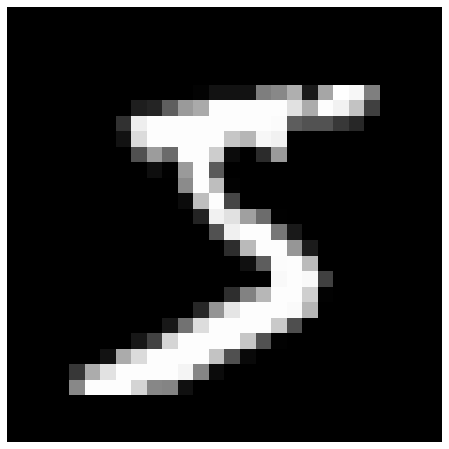

In [12]:
for images, _ in train_loader:
    print('images,shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image,nrow=16).permute((1,2,0)))
    break

Hidden Layers, Activation Functions and Non-Linearity
how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.


First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [13]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1,784)
    print('imputs.shape:',inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
imputs.shape: torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 64. This number can be increased or decreased to change the learning capacity of the model.

In [14]:
input_size = inputs.shape[-1]
hidden_size =64

In [15]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing inputs through layer1.

In [16]:
inputs.shape


torch.Size([128, 784])

In [17]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:',layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 64])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose

In [18]:
layer1_outputs_direct = inputs @layer1.weight.t()+layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 64])

In [19]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

use the F.relu method to apply ReLU to the elements of a tensor.

In [20]:
F.relu(torch.tensor([[1,-2,0],[-0.1,.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

apply the activation function to layer1_outputs and verify that negative values were replaced with 0.

In [22]:
relu_outputs=F.relu(layer1_outputs)
print('min(layer1_outputs):',torch.min(layer1_outputs).item())
print('min(relu_outputs):',torch.min(relu_outputs).item())

min(layer1_outputs): -0.6810014843940735
min(relu_outputs): 0.0


let's create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [39]:
output_size =10
layer2 =nn.Linear(hidden_size, output_size)

In [40]:
layer2_ouputs=layer2(relu_outputs)
print(layer2_ouputs)

tensor([[-0.2238,  0.0979,  0.0921,  ...,  0.0119, -0.1816,  0.0997],
        [-0.2256,  0.2145,  0.2192,  ..., -0.1529, -0.1292,  0.0598],
        [-0.1963,  0.0092,  0.0234,  ..., -0.0303, -0.2244,  0.0883],
        ...,
        [-0.2208,  0.1983,  0.2024,  ..., -0.0803, -0.1269,  0.0901],
        [-0.2486,  0.2485,  0.2301,  ..., -0.1206, -0.0775, -0.0417],
        [-0.1927,  0.1583,  0.1325,  ..., -0.0321, -0.0854, -0.0111]],
       grad_fn=<AddmmBackward>)


layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [41]:
F.cross_entropy(layer2_ouputs,labels)

tensor(2.3206, grad_fn=<NllLossBackward>)

our model transforms inputs into layer2_outputs by applying a linear transformation (using layer1), followed by a non-linear activation (using F.relu), followed by another linear transformation (using layer2). Let's verify this by re-computing the output using basic matrix operations.

In [42]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs =( F.relu(inputs@layer1.weight.t()+layer1.bias))@layer2.weight.t()+layer2.bias

In [43]:
torch.allclose(outputs,layer2_ouputs,1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.
The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function.

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.
If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [45]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs@layer1.weight.t()+layer1.bias)@layer2.weight.t()+layer2.bias
outputs2


tensor([[-0.1330,  0.0232,  0.1974,  ...,  0.0487, -0.1887,  0.0902],
        [-0.1612,  0.1909,  0.3098,  ..., -0.1813, -0.0664, -0.0511],
        [-0.1860, -0.0602,  0.0680,  ...,  0.0558, -0.2296,  0.0656],
        ...,
        [-0.1352,  0.1092,  0.3813,  ..., -0.0292, -0.1088, -0.0266],
        [-0.2414,  0.2746,  0.2559,  ..., -0.0635, -0.0474, -0.0908],
        [-0.1966,  0.0917,  0.1957,  ...,  0.0732, -0.0874, -0.0846]],
       grad_fn=<AddBackward0>)

In [47]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)
combined_layer.weight.data= layer2.weight@layer1.weight
combined_layer.bias.data=layer1.bias@layer2.weight.t()+layer2.bias
combined_layer.weight.data,combined_layer.bias.data

(tensor([[-6.8571e-03, -1.1927e-02,  1.7962e-02,  ...,  4.5137e-03,
          -1.8537e-02, -3.4834e-03],
         [-1.2102e-02,  7.4426e-03, -1.9773e-02,  ..., -1.6559e-02,
          -4.5197e-05, -1.5673e-03],
         [-1.4430e-02, -2.5943e-03,  1.3884e-02,  ..., -7.2665e-03,
          -1.7290e-02, -2.8490e-02],
         ...,
         [-4.8138e-03,  5.7340e-03,  7.6974e-03,  ..., -5.1753e-03,
           2.4489e-02,  4.8596e-03],
         [-1.0800e-02, -9.1551e-03, -1.8609e-02,  ..., -1.2222e-02,
           2.1270e-03, -2.8671e-03],
         [ 1.3171e-02, -5.6174e-03,  5.7840e-03,  ...,  2.5876e-02,
           2.1001e-03, -4.7757e-03]]),
 tensor([-0.1221,  0.1194,  0.1183, -0.0443, -0.0637,  0.0495, -0.0152, -0.0665,
         -0.1015,  0.0421]))

In [49]:
outputs3 = inputs@combined_layer.weight.t()+combined_layer.bias
outputs3

tensor([[-0.1330,  0.0232,  0.1974,  ...,  0.0487, -0.1887,  0.0902],
        [-0.1612,  0.1909,  0.3098,  ..., -0.1813, -0.0664, -0.0511],
        [-0.1860, -0.0602,  0.0680,  ...,  0.0558, -0.2296,  0.0656],
        ...,
        [-0.1352,  0.1092,  0.3813,  ..., -0.0292, -0.1088, -0.0266],
        [-0.2414,  0.2746,  0.2559,  ..., -0.0635, -0.0474, -0.0908],
        [-0.1966,  0.0917,  0.1957,  ...,  0.0732, -0.0874, -0.0846]],
       grad_fn=<AddBackward0>)

In [50]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [52]:
# Install the library
!pip install jovian --upgrade --quiet

In [53]:
import jovian
jovian.commit(project='04-feedforward-nn')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: The detected/provided file "3_lesson_practice_by using other dataset.ipynb" does not exist. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".
